# Regridding
regrid NSIDC sea ice concentration onto an ACCESS-OM2 T grid  using xESMF

see https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Regridding.html
and https://xesmf.readthedocs.io

Slack discussion: https://arccss.slack.com/archives/C08KM5KS6/p1619069437037300

In [20]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import xarray as xr
from dask.distributed import Client

import xesmf
import os

In [27]:
# load obs
obsfile = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3/south/monthly/seaice_conc_monthly_sh_f08_198708_v03r01.nc'
obs_SH = xr.open_dataset(obsfile)
obs_SH = obs_SH.goddard_merged_seaice_conc_monthly

In [28]:
def G02202_obs_regridder(grid_in, grid_out, method='bilinear', periodic=True, **kwargs):
    '''Return a function that takes one dataarray argument on grid_in and returns that dataarray regridded onto grid_out.
    
    grid_in -- path to a NSIDC G02202 NetCDF grid file
    grid_out -- path to a MOM grid file (tracer points are used)
    '''
    weightfn = '_'.join(['regrid', 'weights', os.path.splitext(os.path.basename(grid_in))[0],
                         'to', os.path.splitext(os.path.basename(grid_out))[0], method])+'.nc'
    ds_in = xr.open_dataset(grid_in)\
             .rename({'xgrid': 'x', 'ygrid': 'y',
                     'longitude': 'lon', 'latitude': 'lat'})
    try: # for /g/data/ik11/grids/ocean_grid_10.nc and /g/data/ik11/grids/ocean_grid_025.nc
        ds_out = xr.open_dataset(grid_out).rename({'xt_ocean': 'x', 'yt_ocean': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})
    except ValueError: # for /g/data/ik11/grids/ocean_grid_01.nc           
        ds_out = xr.open_dataset(grid_out).rename({'grid_x_T': 'x', 'grid_y_T': 'y', 'geolon_t': 'lon', 'geolat_t': 'lat'})         

    # shift longitude range of ds_in to match ds_out (making limits integers)
    # this doesn't make any difference to the missing data
    lon_out_min = np.floor(ds_out.lon.min().item(0))
    lon_out_max = np.ceil(ds_out.lon.max().item(0))
    print(lon_out_min, lon_out_max - 360.0, lon_out_max)
    print(ds_in.lon.min().item(0), ds_in.lon.max().item(0), ds_out.lon.min().item(0))
#     ds_in = ds_in.assign_coords(lon=(((ds_in.lon - lon_out_max) % 360) + lon_out_min))
    ds_in = ds_in.assign_coords(lon=(((ds_in.lon - lon_out_max) % 360) + lon_out_max - 360.0))
#     ds_in.coords['lon'] = ((ds_in.lon - lon_out_max) % 360) + lon_out_min
    print(ds_in.lon.min().item(0), ds_in.lon.max().item(0), ds_out.lon.min().item(0))

    # make regridder
    rg = xesmf.Regridder(ds_in, ds_out, method=method, periodic=periodic, reuse_weights=False, #os.path.exists(weightfn), 
                         filename=weightfn, **kwargs)

    def outf(da): # define regridding function to output
        outds = rg(da)
        outds.coords['x'] = ds_out['x']
        outds.coords['y'] = ds_out['y']
        return outds.rename({'x': 'xt_ocean', 'y': 'yt_ocean', 'lon': 'longitude', 'lat': 'latitude'})

    return outf

# define regridder function
regrid_SHobs_to_1 = G02202_obs_regridder(obsfile, '/g/data/ik11/grids/ocean_grid_10.nc')

-280.0 -280.0 80.0
-179.818109247503 179.818109247503 -279.9911193847656
-279.9862604016048 79.99202019855869 -279.9911193847656


In [29]:
obs_SH

<xarray.DataArray 'goddard_merged_seaice_conc_monthly' (time: 1, ygrid: 332, xgrid: 316)>
[104912 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1987-08-01
  * ygrid      (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid      (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
    latitude   (ygrid, xgrid) float64 ...
    longitude  (ygrid, xgrid) float64 ...
Attributes:
    valid_range:    [  0 100]
    long_name:      Goddard Edited Climate Data Record of Passive Microwave M...
    standard_name:  sea_ice_area_fraction
    units:          1
    flag_values:    [-5 -4 -3 -2 -1]
    flag_meanings:  pole_hole lakes coastal land_mask missing_data
    datum:          +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:   projection
    reference:      http://nsidc.org/data/nsidc-0051.html http://nsidc.org/da...

In [38]:
# apply regridder function
obs_SH_regridded = regrid_SHobs_to_1(obs_SH)
obs_SH_regridded

<xarray.DataArray 'goddard_merged_seaice_conc_monthly' (time: 1, yt_ocean: 300, xt_ocean: 360)>
array([[[2.53999996, 2.53999996, 2.53999996, ..., 2.53999996,
         2.53999996, 2.53999996],
        [2.53999996, 2.53999996, 2.53999996, ..., 2.53999996,
         2.53999996, 2.53999996],
        [2.53999996, 2.53999996, 2.53999996, ..., 2.53999996,
         2.53999996, 2.53999996],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * time       (time) datetime64[ns] 1987-08-01
    longitude  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 79.97 79.99
    latitude   (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 65.63 65.21
  * xt_ocean   (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean   (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
Attributes:
    regrid_method:  bilinear

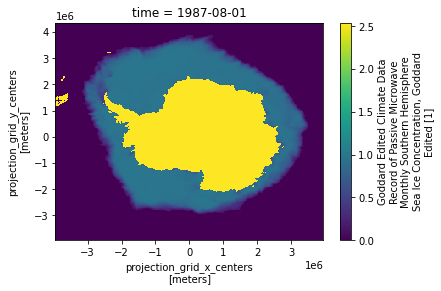

In [31]:
obs_SH.plot()

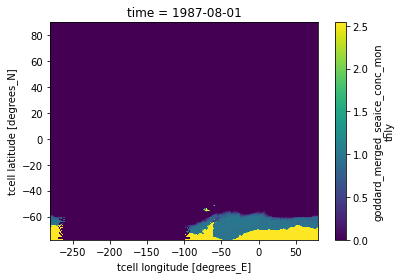

In [32]:
obs_SH_regridded.plot() # missing data from about -280 to -80 longitude

## Old and new grid longitudes differ in the range -280 to -180E, but this isn't the range over which data is missing
Colours show longitude (colour scales are the same)

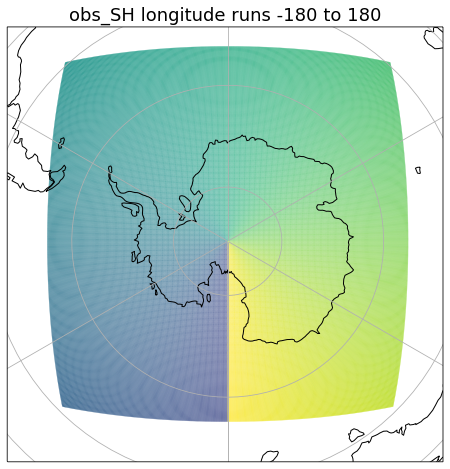

In [37]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.cartopy.crs.Orthographic(central_longitude=0.0, central_latitude=-90))
ax.coastlines()
ax.gridlines()
ax.scatter(obs_SH['longitude'], obs_SH['latitude'], 
           c=obs_SH['longitude'], vmin=-280, vmax=180, s=0.1, 
           transform=ccrs.PlateCarree())  # plot grid locations
ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
plt.title('obs_SH longitude runs -180 to 180', fontsize=18);

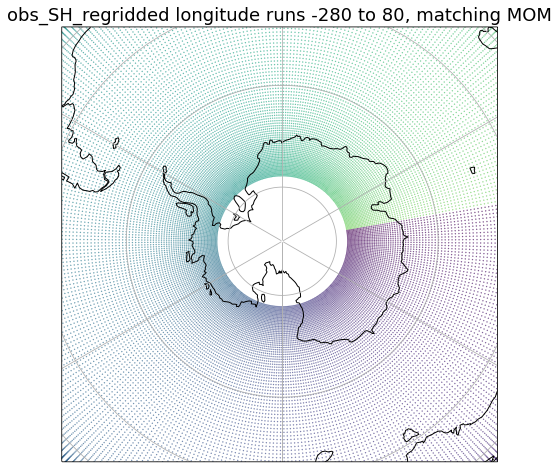

In [36]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.cartopy.crs.Orthographic(central_longitude=0.0, central_latitude=-90))
ax.coastlines()
ax.gridlines()
ax.scatter(obs_SH_regridded['longitude'], obs_SH_regridded['latitude'], 
           vmin=-280, vmax=180, c=obs_SH_regridded['longitude'], s=0.1, 
           transform=ccrs.PlateCarree())  # plot grid locations
ax.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
plt.title('obs_SH_regridded longitude runs -280 to 80, matching MOM', fontsize=18);